The aim of this notebook is to translate a PDF file in different languages. In particular, both the regular text and the one present in the images will be translated.

The adopted translation engine is Google Translate, which allows translations between 106 languages.

In [1]:
import googletrans
languages = googletrans.LANGCODES

The origial language and the desired translation language must be specified.

**Select the languages:**
 

In [6]:
from_lang = languages["english"]
to_lang = languages["italian"]

A PDF file will be fetched from the "input" folder.

**Type in the file's name:**

In [7]:
#file_name = "Volume 1 SRS ETCS L2 su rete convenzionale_firmato.pdf"

file_name = "python_project_report_GROUP_20.pdf"

In [8]:
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
import img2pdf
import tempfile
import os

output_name = file_name.rstrip(".pdf") + "_" + to_lang + ".pdf"

file_path = os.path.join("..", "input", file_name)

output_path = os.path.join("..", "output", output_name)

FONT_FAMILY = os.path.join("..", "input", "arial.ttf")

def convert_pdf_to_images(pdf_path):
    return convert_from_path(pdf_path)

# Convert the PDF file to a list of images
immagini = convert_pdf_to_images(file_path)
# Create a copy to be used for the first output file: the one marked 
# with the problematic areas
immagini_da_contrassegnare = immagini.copy()

In [9]:
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LTTextBoxHorizontal

resource_manager = PDFResourceManager()  

The following parameters can be tuned so that the text in the PDF file will be read correctly. The documentation for these parameters can be found [here.](https://pdfminersix.readthedocs.io/en/latest/reference/composable.html)

The following cells can be executed in order to check visually whether the paragraphs are being correctly identified.

**Adjust the parameters' values:**

In [12]:
# use this for "Volume 1 SRS ETCS L2 su rete convenzionale_firmato.pdf"
"""
laparams = LAParams(line_overlap=0.5,char_margin=1.4, line_margin=0.125,\
word_margin=0.1, boxes_flow=0.5, detect_vertical=False, all_texts=True)
"""
# use this for "python_project_report_GROUP_20.pdf"

laparams = LAParams(line_overlap=0.5,char_margin=1.4, line_margin=0.6,\
word_margin=0.1, boxes_flow=0.5, detect_vertical=False, all_texts=True)

In [13]:
device = PDFPageAggregator(resource_manager, laparams=laparams)

interpreter = PDFPageInterpreter(resource_manager, device)

pagine_pre_proc = []
dimensioni_pagine = []
with open(file_path, 'rb') as fp:
    for page in PDFPage.get_pages(fp):
        mediabox = page.mediabox
        width = mediabox[2] - mediabox[0]
        height = mediabox[3] - mediabox[1]
        dimensioni_pagine.append([width, height])
        interpreter.process_page(page)
        layout = device.get_result()
        pagine_pre_proc.append(layout)

# All the paragraphs are moved into a list where each element is a list 
#(page) storing the page's paragraphs

pagine = []
for pagina in pagine_pre_proc:
    pag = []
    for elemento in pagina:
        if isinstance(elemento, LTTextBoxHorizontal):
            pag.append(elemento)
    pagine.append(pag)

A page of the PDF file can be chosen so that in the following cells, an image will be created where the text paragraphs which were identified will be highlighted through some bounding boxes. From now on, these will be referred to as "text boxes".

This can be used as a feedback for the parameters tuning.

**Select a page:**

In [14]:
page_num = 2

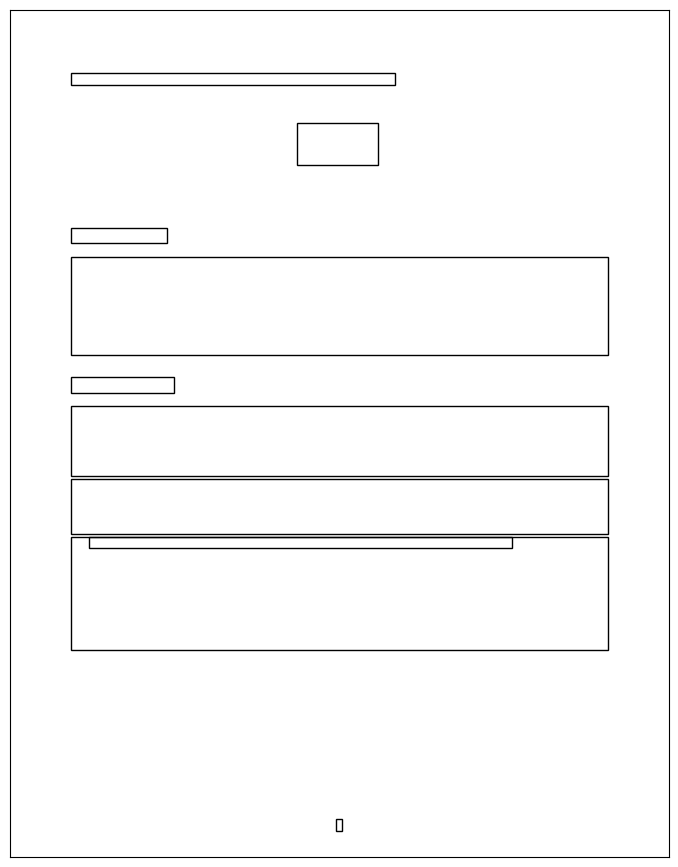

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pdfminer.layout import LTTextBoxHorizontal

# Create a new figure with size matching paper dimensions in points 

width = dimensioni_pagine[0][0]
height = dimensioni_pagine[0][1]

fig = plt.figure(figsize=(width/72, height/72))  # Convert points to inches

# Create a subplot
ax = fig.add_subplot(111)

# Function to add a square given bottom-left and top-right corners in points
def add_square(bl_x, bl_y, tr_x, tr_y):
    """
    Function to add a square given bottom-left and top-right corners'  
    coordinates.
    """
    # Calculate width and height based on the coordinates
    width = tr_x - bl_x
    height = tr_y - bl_y

    # Convert the width and height from points to inches
    width_in = width / 72
    height_in = height / 72

    # Convert the bottom-left corner coordinates from points to inches
    bl_corner_in = (bl_x / 72, bl_y / 72)

    # Add a square at specified coordinates with calculated width and height
    square = patches.Rectangle(bl_corner_in, width_in, height_in, \
                               fill=False)
    ax.add_patch(square)

for elemento in pagine[0]:
    if isinstance(elemento, LTTextBoxHorizontal):
        add_square(elemento.x0, elemento.y0, elemento.x1, elemento.y1)
# Set limits to match paper size
ax.set_xlim(0, width/72)
ax.set_ylim(0, height/72)

# Display the plot
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Overlapping of two or more text boxes may impact the quality of the translation. Therefore, a PDF file will be now created showing exactly which parts of the original PDF will result in overlapping text boxes, so that the user can modify the original PDF to solve this issue, in case the parameters chosen work well for most of the text but there are still some problematic areas.

In [16]:
from PIL import Image, ImageDraw

def bubblesort(pagine):
    """
    This function sorts the pages' paragraphs in row-major order.
    """
    # Sorting the y
    for pag in pagine:
        for iter_num in range(len(pag)-1,0,-1):
            for idx in range(iter_num):
                if pag[idx].bbox[1] < pag[idx+1].bbox[1]:
                    temp = pag[idx]
                    pag[idx] = pag[idx+1]
                    pag[idx+1] = temp
     # Sorting the x
    for iter_num in range(len(pag)-1,0,-1):
        for idx in range(iter_num):
            if pag[idx].bbox[1] == pag[idx+1].bbox[1] and \
                pag[idx].bbox[0] > pag[idx+1].bbox[0]:
                temp = pag[idx]
                pag[idx] = pag[idx+1]
                pag[idx+1] = temp
    
bubblesort(pagine)

def found_intersection(elemento, pagina):
    """
    This function checks if there is an overlapping between two 
    paragraphs.
    """
    for elem in pagina:
        if elem.bbox[1] < elemento.bbox[3] < elem.bbox[3] and \
           elem.bbox[0] < elemento.bbox[0] and \
           elemento.bbox[2] < elem.bbox[2]:
            return elem
        elif elem.bbox[1] < elemento.bbox[1] < elem.bbox[3] and \
           elem.bbox[0] < elemento.bbox[0] and \
           elemento.bbox[2] < elem.bbox[2]:
            return elem
    return False

pagine_contrassegnate = []
for pagina in pagine: 
    pagina_contrassegnata = []
    for elemento in pagina:
        if isinstance(elemento, LTTextBoxHorizontal):
            elem = found_intersection(elemento, pagina)
            if elem:
                pagina_contrassegnata.append(elem)
                pagina_contrassegnata.append(elemento)
    pagine_contrassegnate.append(pagina_contrassegnata)
    
def convert_images_to_pdf(images, output_path):
    """
    This function takes as input an array of images, which it converts to
    a PDF file and saves at the specified location.
    """
    with tempfile.TemporaryDirectory() as tempdir:
        image_files = []
        for i, image in enumerate(images):
            image_file = os.path.join(tempdir, f'image{i}.png')
            image.save(image_file)
            image_files.append(image_file)
        with open(output_path, "wb") as f:
            f.write(img2pdf.convert(image_files))

def calcola_coordinate(bl_x, bl_y, tr_x, tr_y, width_pag, height_pag,\
                       width_img, height_img):
    """
    In order to account for the different position of the origin of the
    reference systems (pages and images), this function will translate 
    a pair of points' coordinates in the page reference system to the 
    image reference system. 
    """
    bl_x_new = bl_x * width_img / width_pag
    bl_y_new = height_img - bl_y * height_img / height_pag
    tr_x_new = tr_x * width_img / width_pag
    tr_y_new = height_img - tr_y * height_img / height_pag
    return bl_x_new, bl_y_new, tr_x_new, tr_y_new

def add_red_box(img, coor):
    """
    This function draws a red box arounf the text box that is passed to 
    it as input. 
    """
    draw = ImageDraw.Draw(img)
    rect_coords = [(coor[0], coor[3]), (coor[2], coor[1])]
    draw.rectangle(rect_coords, outline='red')
    return img

# Iterating through the pages, all text boxes showing overlapping will 
# be highlighted in red

for immagine, pagina, dimensioni_pagina in zip(immagini_da_contrassegnare,\
                                 pagine_contrassegnate, dimensioni_pagine):
    if len(pagina) == 0:
        continue
    else:
        width_pag, height_pag = dimensioni_pagina[0], dimensioni_pagina[1]
        width_img, height_img = immagine.size
        for par in pagina:
            coordinate = calcola_coordinate(*par.bbox, width_pag,\
                     height_pag, width_img, height_img )
            immagine = add_red_box(immagine, coordinate)

convert_images_to_pdf(immagini_da_contrassegnare, \
output_path.rstrip(".pdf")[:-3] + "_MARKED.pdf")    

Now all the text detected in the original image will be canceled by applying white rectangles over it.

In [17]:
def add_rectangle_to_image(image, coordinates):
    """
    This function draws a white rectangle (patch) on the specified page
    and within the specified coordinates of the bottom-left and top-right
    vertices.
    """
    draw = ImageDraw.Draw(image)
    draw.rectangle((coordinates[0], coordinates[3], coordinates[2], \
                    coordinates[1]), fill="white")
    return image

for dimensioni_pagina, pagina, immagine in zip(dimensioni_pagine, \
                                               pagine, immagini):
    for paragrafo in pagina:
        width_pag, height_pag = dimensioni_pagina[0], dimensioni_pagina[1]
        width_img, height_img = immagine.size
        coordinate = calcola_coordinate(*paragrafo.bbox, width_pag,\
                     height_pag, width_img, height_img)
        # add a white rectangle 
        immagine = add_rectangle_to_image(immagine, coordinate)

At this stage, the pages stored in the "immagini" variable will only contain the images detected in the original PDF file. 

Therefore, any text present in these images can now be extracted using OCR techniques.

In [18]:
from pytesseract import image_to_data, image_to_string, image_to_boxes
import cv2
import numpy as np

In [19]:
def group_by_y0_tolerance(data, tolerance=0.6):
    """
    This function groups characters laying on the same row.
    """
    grouped = []
    for item in data:
        # Convert strings to floats for comparison
        y0 = float(item[2])
        y1 = float(item[4])
        y_diff = y1 - y0
        # Check if the item can be added to an existing group
        added_to_group = False
        for group in grouped:
            group_y0 = np.mean([float(element[2]) for element in group])
            if abs(y0 - group_y0) <= abs(tolerance * y_diff):
                group.append(item)
                added_to_group = True
                break
        # If the item wasn't added to an existing group, create a new one
        if not added_to_group:
            grouped.append([item])
    # Sanity check
    for group in grouped:
        # Average height of the characters of a string
        avg_delta_y = np.mean([float(item[4])-float(item[2])\
                               for item in group])
        i = 0
        while i < len(group):
            # If the character's height is greater than 5 times the 
            # other characters' height
            if (float(group[i][4])-float(group[i][2])) > 5*avg_delta_y:
                del group[i]
            else:
                i += 1
    return grouped

class TextBox:
    """
    This is a shallow clone of the LTTextBox class, used to creates
    instances of it.
    """
    def __init__(self, x0 = 0.0, y0 = 0.0, x1 = 0.0, y1 = 0.0, text = ""):
        self.x0 = float(x0)
        self.y0 = float(y0)
        self.x1 = float(x1)
        self.y1 = float(y1)
        self.text = str(text)
        self.bbox = [x0, y0, x1, y1]
    
    def get_text(self):
        return self.text
    
    def getbbox(self):
        return [self.x0, self.y0, self.x1, self.y1]
    
    def set_attributes(self, x0=None, y0=None, x1=None, y1=None, text=None):
        if x0 is not None:
            self.x0 = float(x0)
            self.bbox = [self.x0, self.y0, self.x1, self.y1]
        if y0 is not None:
            self.y0 = float(y0)
            self.bbox = [self.x0, self.y0, self.x1, self.y1]
        if x1 is not None:
            self.x1 = float(x1)
            self.bbox = [self.x0, self.y0, self.x1, self.y1]
        if y1 is not None:
            self.y1 = float(y1)
            self.bbox = [self.x0, self.y0, self.x1, self.y1]
        if text is not None:
            self.text = str(text)

def create_text_boxes(grouped_data):
    """
    This function brakes a row into a sentence and creates a TextBox 
    object for every sentence.
    """
    text_boxes = []
    for group in grouped_data:
        if not group: continue # if group is empty, skip to the next group
        text_box = TextBox(x0 = float(group[0][1]), y0 = float(group[0][2]))
        string = group[0][0] # Start string with the first character of the group
        for i in range(1, len(group)):
            prev_item = group[i-1]
            curr_item = group[i]
            prev_x0 = float(prev_item[1])
            prev_x1 = float(prev_item[3])
            curr_x0 = float(curr_item[1])
            curr_x1 = float(curr_item[3])
            if curr_x0 - prev_x1 > 1.5 * (curr_x1 - curr_x0):
                text_box.set_attributes(text = string)
                text_box.set_attributes(x1 = \
                    max([float(item[3]) for item in group[:i]]))
                text_box.set_attributes(y1 = float(prev_item[4]))
                text_boxes.append(text_box)
                if i == len(group)-1:
                    break
                else:
                    text_box = TextBox(x0 = float(curr_item[1]), y0 = float(curr_item[2]))
                    string = curr_item[0]
                    continue
            elif curr_x0 - prev_x1 > 0.35 * (curr_x1 - curr_x0):
                string += " " + curr_item[0] # Append a white space 
                                            #before the current character
                if i != len(group)-1:
                    continue
            else:
                string += curr_item[0] # Append the current character
                if i != len(group)-1:
                    continue
            text_box.set_attributes(text = string)
            text_box.set_attributes(x1 = \
                      max([float(item[3]) for item in group[:i]]))
            text_box.set_attributes(y1 = float(group[i][4]))
            text_boxes.append(text_box)
    return text_boxes

pagine_immagini = []
for img, pagina, dimensioni_pagina in zip(immagini, pagine, dimensioni_pagine):
    pagina_immagine = []
    width_pag, height_pag = dimensioni_pagina[0], dimensioni_pagina[1]
    width_img, height_img = immagine.size
    data_str = ""
    data_str += image_to_boxes(img)
    if data_str:
        data = data_str.split("\n")
        data = [datum.split() for datum in data if datum] 
        data = [datum for datum in data if datum[0] != "~"]
        grouped_data = group_by_y0_tolerance(data)
        text_boxes = create_text_boxes(grouped_data)
        pagina_immagine = text_boxes[:]
    pagine_immagini.append(pagina_immagine)

Now, the two lists can be merged into one.

In [20]:
pagine_unite = [pagina + pagina_immagine for pagina, pagina_immagine in \
                zip(pagine, pagine_immagini)]

At this stage, the text can be translated and written on the pages images.

In [21]:
from googletrans import Translator
import re

# Loading the Translator object
translator = Translator()

def traduci_paragrafo(paragrafo):
    """
    This function returns the translation for the text stored in a TextBox or LTTextBox 
    object.
    """
    paragrafo_tradotto = translator.translate(paragrafo, src = from_lang,
                                         dest = to_lang)
    return paragrafo_tradotto.text

def is_blank(s):
    return bool(re.match('^ *$', s))

In [22]:
from tqdm import tqdm

def pulisci_paragrafo(testo):
    """
    This function removes the "\n" characters in the strings.
    """
    return testo.replace("\n", " ")

def area_to_char_ratio(coordinate, text):
    """
    This function gives the ratio of the white rectangle area and the 
    number of characters in the paragraph. It is a proxy of the font size.
    """
    return abs(coordinate[0]-coordinate[2])*abs(coordinate[1]\
             -coordinate[3])/(len(text)+0.001) #+0.001 to ensure no 0 div

def compute_font_size(coordinate, text):
    """
    This function uses empyrically obtained value to adjust the font size
    using the area to number of characters ratio.
    """
    y = area_to_char_ratio(coordinate, text) 
    if y > 390:
        return 22
    elif y > 195: 
        # Line y = (390/22) * x
        return round(y*20/390) + 2
    else: 
        return 12

def get_text_dimensions(text, font):
    """
    This function splits the text into lines based on the provided font 
    size and rectangle dimensions.
    """
    ascent, descent = font.getmetrics()
    text_width = font.getmask(text).getbbox()[2]
    text_height = font.getmask(text).getbbox()[3] + descent
    return (text_width, text_height)

def get_font_size(draw, text, font_path, rect_width, rect_height, font_size):
    """
    This function splits the text into lines based on the provided font size and 
    rectangle dimensions.
    """
    font = ImageFont.truetype(font_path, font_size)
    words = text.split()
    lines = []
    current_line = words[0]
    for word in words[1:]:
        # Check if adding another word to the current line would 
        #fit within the rectangle width
        if draw.textlength(' '.join([current_line, word]), \
                         font=font) <= rect_width:
            current_line += ' ' + word
        else:
            # If it doesn't fit, add the current line to the lines list 
            #and start a new line with the current word
            lines.append(current_line)
            current_line = word
    lines.append(current_line)
    return lines

def add_rectangle_and_text_to_image(image, text, coordinates, font_path):
    """
    This function adds margins within the rectangle and draws the text within these margins.
    """
    draw = ImageDraw.Draw(image)
    rect_width = coordinates[2] - coordinates[0]
    rect_height = coordinates[1] - coordinates[3]  # in the image ref sys
    font_size = compute_font_size(coordinates, text)
    lines = get_font_size(draw, text, font_path, rect_width, rect_height,\
                          font_size)
    font = ImageFont.truetype(font_path, font_size)
    draw.rectangle((coordinates[0], coordinates[3], coordinates[2], \
                    coordinates[1]), fill="white")

    current_height = coordinates[3]
    for line in lines:
        draw.text((coordinates[0], current_height), line, \
                  fill="black", font=font)
        ascent, descent = font.getmetrics()
        current_height += ascent + descent

    return image
            
def enlarge_patch_area(bl_x, bl_y, tr_x, tr_y, width_img, height_img):
    """
    Since the images in text would be smaller than the regular text,
    we need to pass enlarged coordinates to the add_rectangle_and_text_
    to_image function.
    This function takes as argument an array of coordinates: bl_x, bl_y, 
    tr_x, tr_y and returns the same array properly scaled.
    """
    new_tr_x = tr_x + 0.2*abs(tr_x-bl_x)
    new_tr_y = tr_y - 0.2*abs(tr_y-bl_y)
    new_bl_x = bl_x - 0.2*abs(tr_x-bl_x)
    new_bl_y = bl_y + 0.2*abs(tr_y-bl_y)
    
    if new_tr_x < width_img and new_tr_y < height_img:
        return [bl_x, bl_y, new_tr_x, new_tr_y]
    elif new_bl_x > 0 and new_bl_y > 0:
        return [new_bl_x, new_bl_y, tr_x, tr_y]
    else:
        return [bl_x, bl_y, tr_x, tr_y]
            
zipped_data = zip(dimensioni_pagine, pagine_unite, immagini)
total_iterations = len(dimensioni_pagine) 

for dimensioni_pagina, pagina, immagine in tqdm(zipped_data, \
    total=total_iterations, desc="Processing pages", unit="page"):
    width_pag, height_pag = dimensioni_pagina[0], dimensioni_pagina[1]
    width_img, height_img = immagine.size
    for paragrafo in pagina:
        testo = pulisci_paragrafo(paragrafo.get_text())
        if is_blank(testo) or testo is None:
            continue
        else:
            try:
                testo = traduci_paragrafo(testo)
                if is_blank(testo) or testo is None:
                    continue
                else:
                    if isinstance(paragrafo, LTTextBoxHorizontal):
                        coordinate = calcola_coordinate(*paragrafo.bbox, \
                                                        width_pag,\
                                 height_pag, width_img, height_img)
                    elif isinstance(paragrafo, TextBox):
                        coordinate = enlarge_patch_area(*[paragrafo.bbox[0],\
                           height_img - paragrafo.bbox[1], paragrafo.bbox[2],\
                           height_img - paragrafo.bbox[3]], width_img, height_img)
                # Add white patch and text to text at the specified 
                # coordinates
                    immagine = add_rectangle_and_text_to_image(immagine, testo, \
                                               coordinate, FONT_FAMILY)
            except:
                continue

# Convert the images array into a PDF document
convert_images_to_pdf(immagini, output_path)

Processing pages: 100%|█████████████████████████| 6/6 [00:20<00:00,  3.41s/page]
